In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

In [2]:
in_submission = os.path.exists('/flags/isgrader.flag')
perform_computation = not in_submission 

if in_submission:
    assert os.path.exists('./cifar_net.pth'), 'The trained network for CIFAR was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    assert os.path.exists('./mnist_net.pth'), 'The trained network for MNIST was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'

# Summary

Go through the CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, and ensure you can run the code. Modify the architecture that is offered in the CIFAR-10 tutorial to get the best accuracy you can. Anything better than about 93.5% will be comparable with current research. 

Redo the same efforts for the MNIST digit data set.

**Procedural Instructions**:

This assignment is less guided than the previous assignments. You are supposed to train a deep convolutional classifier, and store it in a file. The autograder will load the trained model, and test its accuracy on a hidden test data set. Your classifier's test accuracy will determine your grade for each part according to the following model.

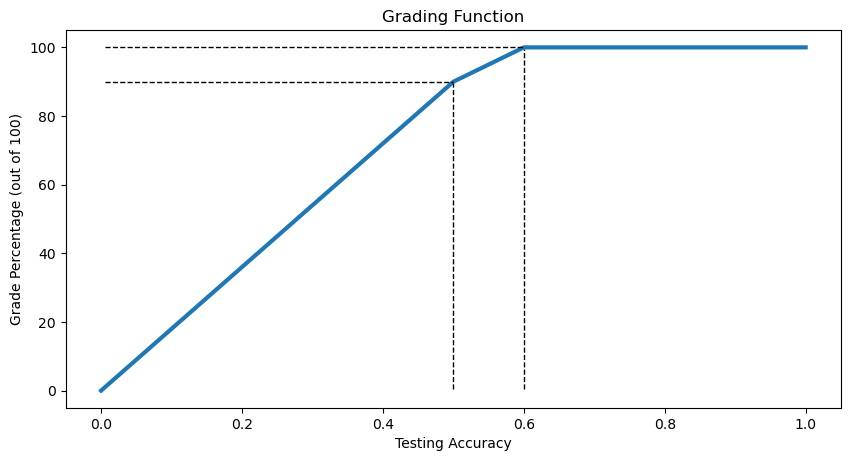

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot([0., 0.5, 0.6, 1.], [0., 90., 100., 100.], lw=3)
ax.axhline(y=90, xmin=0.05, xmax=.5, lw=1, ls='--', c='black')
ax.axvline(x=0.5, ymin=0.05, ymax=.86, lw=1, ls='--', c='black')
ax.axhline(y=100, xmin=0.05, xmax=.59, lw=1, ls='--', c='black')
ax.axvline(x=0.6, ymin=0.05, ymax=.95, lw=1, ls='--', c='black')
ax.set_xlabel('Testing Accuracy')
ax.set_ylabel('Grade Percentage (out of 100)')
ax.set_title('Grading Function')
None

# 1. Object Classification Using the CIFAR Data

## 1.1 Loading the Data

In [4]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# your code here
transform = transforms.Compose(
    [
    transforms.RandomAffine(degrees=30, translate=(0.09, 0.09), scale=(0.5, 1.5)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='/home/jovyan/work/release/CNN-lib/data_cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/jovyan/work/release/CNN-lib/data_cifar', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.
Files already downloaded and verified
Files already downloaded and verified


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


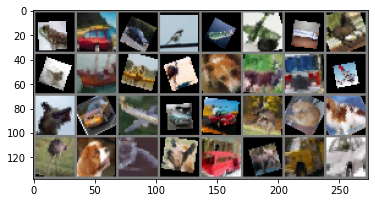

frog  car   car   bird  ship  plane truck horse bird  ship  plane bird  dog   deer  truck plane dog   car   plane car   car   deer  cat   dog   bird  dog   cat   deer  car   deer  truck car  


In [5]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 1.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cpu


In [7]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# your code here
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1024, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(32, 10),
        )
    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x
net = Net().to(device)

You can define the neural architecture and instantiate it in this cell.


# 1.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [8]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here


You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 1.4 Defining The Loss Function and The Optimizer

In [9]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

You can define the loss function and the optimizer of interest here.


# 1.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [10]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    num_epochs = 40

    for epoch in range(num_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          if i % 900 == 0:    # print every 900 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
     
    print('Finished Training')

You can define the training loop and forward-backward propagation here.
[1,     1] loss: 0.001
[1,   901] loss: 0.882
[2,     1] loss: 0.001
[2,   901] loss: 0.744
[3,     1] loss: 0.001
[3,   901] loss: 0.683
[4,     1] loss: 0.001
[4,   901] loss: 0.643
[5,     1] loss: 0.001
[5,   901] loss: 0.619
[6,     1] loss: 0.001
[6,   901] loss: 0.598
[7,     1] loss: 0.001
[7,   901] loss: 0.578
[8,     1] loss: 0.001
[8,   901] loss: 0.564
[9,     1] loss: 0.000
[9,   901] loss: 0.549
[10,     1] loss: 0.001
[10,   901] loss: 0.539
[11,     1] loss: 0.001
[11,   901] loss: 0.528
[12,     1] loss: 0.001
[12,   901] loss: 0.521
[13,     1] loss: 0.001
[13,   901] loss: 0.516
[14,     1] loss: 0.000
[14,   901] loss: 0.500
[15,     1] loss: 0.000
[15,   901] loss: 0.498
[16,     1] loss: 0.001
[16,   901] loss: 0.490
[17,     1] loss: 0.001
[17,   901] loss: 0.484
[18,     1] loss: 0.001
[18,   901] loss: 0.482
[19,     1] loss: 0.000
[19,   901] loss: 0.474
[20,     1] loss: 0.001
[20,   901

In [11]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    num_epochs = 25

    for epoch in range(num_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          if i % 900 == 0:    # print every 900 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
     
    print('Finished Training')

You can define the training loop and forward-backward propagation here.
[1,     1] loss: 0.000
[1,   901] loss: 0.414
[2,     1] loss: 0.001
[2,   901] loss: 0.412
[3,     1] loss: 0.000
[3,   901] loss: 0.413
[4,     1] loss: 0.000
[4,   901] loss: 0.403
[5,     1] loss: 0.001
[5,   901] loss: 0.402
[6,     1] loss: 0.001
[6,   901] loss: 0.404
[7,     1] loss: 0.000
[7,   901] loss: 0.402
[8,     1] loss: 0.000
[8,   901] loss: 0.402
[9,     1] loss: 0.000
[9,   901] loss: 0.402
[10,     1] loss: 0.000
[10,   901] loss: 0.398
[11,     1] loss: 0.000
[11,   901] loss: 0.390
[12,     1] loss: 0.000
[12,   901] loss: 0.395
[13,     1] loss: 0.000
[13,   901] loss: 0.395
[14,     1] loss: 0.001
[14,   901] loss: 0.397
[15,     1] loss: 0.000
[15,   901] loss: 0.392
[16,     1] loss: 0.000
[16,   901] loss: 0.389
[17,     1] loss: 0.000
[17,   901] loss: 0.390
[18,     1] loss: 0.001
[18,   901] loss: 0.390
[19,     1] loss: 0.000
[19,   901] loss: 0.388
[20,     1] loss: 0.000
[20,   901

# 1.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [12]:
message = 'Here you should store the model at "./cifar_net.pth" .'
print(message)

if perform_computation:
    # your code here
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)

Here you should store the model at "./cifar_net.pth" .


# 1.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


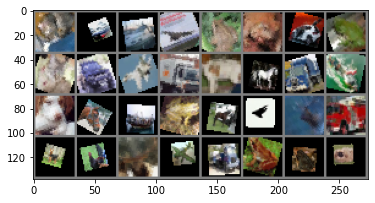

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


In [13]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [14]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 69 %


In [15]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 69 %


## 1.8 Autograding and Final Tests

In [18]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

cifar_net_path = './cifar_net.pth'

assert os.path.exists(cifar_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(cifar_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'



if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(cifar_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

test_pre_tranformation = transforms.Compose(transformation_list)

cifar_root = '/home/jovyan/work/release/CNN-lib/data_cifar' 
testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False,
                                       download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of plane : 80 %
Accuracy of   car : 90 %
Accuracy of  bird : 63 %
Accuracy of   cat : 56 %
Accuracy of  deer : 68 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 82 %
Accuracy of  ship : 87 %
Accuracy of truck : 84 %
----------
Overall Testing Accuracy: 78.05 %%


In [19]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# 2. Digit Recognition Using the MNIST Data

## 2.1 Loading the Data

In [20]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

# your code here
transform = transforms.Compose(
    [transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), scale=(0.5, 2.)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='/home/jovyan/work/release/CNN-lib/data_mnist', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='/home/jovyan/work/release/CNN-lib/data_mnist', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = list(str(i) for i in range(10))

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


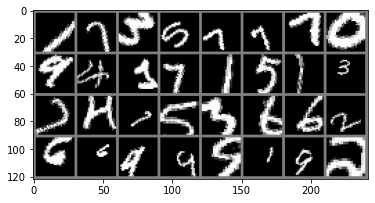

1     7     3     5     7     7     7     0     9     4     1     7     1     5     1     3     7     4     7     5     3     6     6     2     6     6     9     9     9     1     9     2    


In [21]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [22]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)


# your code here
class Net(nn.Module):
   

    def __init__(self):
        
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(576, 16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(16, 10),
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        # print(x.size())
        # fc layer
        x = self.fc_layer(x)

        return x

net = Net().to(device)

You can define the neural architecture and instantiate it in this cell.


# 2.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [23]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 2.4 Defining The Loss Function and The Optimizer

In [24]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

You can define the loss function and the optimizer of interest here.


# 2.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [25]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    num_epochs = 1

    for epoch in range(num_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          if i % 500 == 0:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
     
    print('Finished Training')

You can define the training loop and forward-backward propagation here.
[1,     1] loss: 0.001
[1,   501] loss: 0.452
[1,  1001] loss: 0.272
[1,  1501] loss: 0.191
Finished Training


# 2.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [26]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

if perform_computation:
  PATH = './mnist_net.pth'
  torch.save(net.state_dict(), PATH)


Here you should store the model at "./mnist_net.pth" .


# 2.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


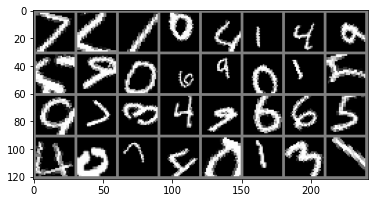

GroundTruth:  7     2     1     0    


In [27]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 80 %


In [29]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 81 %


## 2.8 Autograding and Final Tests

In [30]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                 'Make sure you read and follow the instructions provided as Important Notes' + \
                                 '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. ' + \
                                      'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

mnist_root = '/home/jovyan/work/release/CNN-lib/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of     0 : 94 %
Accuracy of     1 : 94 %
Accuracy of     2 : 74 %
Accuracy of     3 : 94 %
Accuracy of     4 : 72 %
Accuracy of     5 : 83 %
Accuracy of     6 : 82 %
Accuracy of     7 : 79 %
Accuracy of     8 : 70 %
Accuracy of     9 : 76 %
----------
Overall Testing Accuracy: 82.47 %%


In [ ]:
# "Digit Recognition Test: Checking the accuracy on the MNIST Images"
